# 1. Theory: What is a Graph Convolution?

## Analogy
Just like CNNs apply convolutions on pixel grids,

GNNs apply convolutions on graphs by aggregating information from each node’s neighbors.


$$H^{(l+1)}=σ(D~^{−1/2}A~D~^{−1/2}H^{l}W^{l})$$

- 𝐴: adjacency matrix with self-loops

- 𝐷: degree matrix

- $H^l$: node representations at layer l

- $𝑊^l$: learnable weights

- σ: activation (e.g., ReLU)

> Each node updates its feature by averaging neighbors’ features + itself.

## Practice

In [4]:
# Download Dataset Cora
# Build 2 layer GCN

In [ ]:
#!pip install torch_geometric sklearn numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
from torch_geometric.datasets import Planetoid

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

dataset = Planetoid(root="data/Planetoid", name="Cora") # Dataset: Cora
data = dataset[0]
print(data)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels , hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
        

In [6]:
model = GCN(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=5e-4)
data = dataset[0]

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, loss={loss:.4f}')
        
        
    

Epoch 000, loss=1.9563
Epoch 020, loss=0.2997
Epoch 040, loss=0.0597
Epoch 060, loss=0.0301
Epoch 080, loss=0.0382
Epoch 100, loss=0.0524
Epoch 120, loss=0.0392
Epoch 140, loss=0.0258
Epoch 160, loss=0.0350
Epoch 180, loss=0.0304


In [7]:
model.eval()
out = model(data)
pred = out.argmax(dim=1)

correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy = {acc:4f}')



Accuracy = 0.800000


In [9]:
## Visual nodes embedding

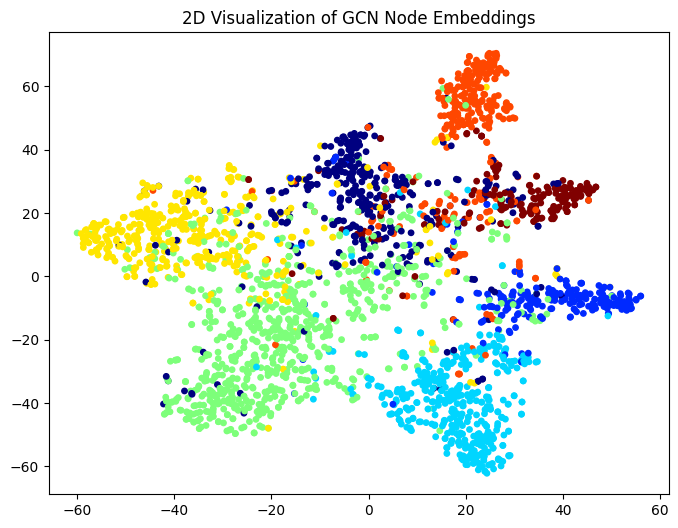

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model.eval()
z = model.conv1(data.x, data.edge_index).detach()

z_2d = TSNE(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(z_2d[:,0], z_2d[:,1], c=data.y, cmap='jet', s=15)
plt.title('2D Visualization of GCN Node Embeddings')
plt.show()


Problem definition: 

Universal framework of GNN

$$h_v^0 = X_v$$

For l = 1,2,..., l
1. $m_v = f^l (h_v^l,{h_v^l: n E N(v)})$
2. $h_v^{l+1} = g^l(m_v^l)$

Notation: $h_v^l$: v's embedding ât layer l

## EX1: Hyperparameter Tuning

In [9]:
# Hyperparameter Tuning
# Experiment with:
# Hidden size (8, 32, 64)
# Learning rate (0.005, 0.01, 0.02)
# Dropout (0.3, 0.5, 0.7)
#   Log accuracy vs. parameters and observe what changes.

In [10]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Move data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

print(f"Dataset: {dataset.name}")
print(f"Nodes: {data.num_nodes}")
print(f"Features: {dataset.num_features}")
print(f"Classes: {dataset.num_classes}")

Dataset: Cora
Nodes: 2708
Features: 1433
Classes: 7


Processing...
Done!


In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout_rate = dropout_rate # Store dropout rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Apply dropout during training
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [12]:
def train(model, optimizer, data):
    model.train() # Set model to training mode (for dropout)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # Calculate loss only on training nodes
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(model, data):
    model.eval() # Set model to evaluation mode (disables dropout)
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    # Check accuracy on validation nodes
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(correct) / int(data.val_mask.sum())
    return val_acc

In [14]:
import itertools

# 1. Define the parameter grid
hidden_sizes = [8, 32, 64]
learning_rates = [0.005, 0.01, 0.02]
dropouts = [0.3, 0.5, 0.7]

# Create all combinations
param_grid = list(itertools.product(hidden_sizes, learning_rates, dropouts))

print(f"\nStarting Grid Search... Total combinations: {len(param_grid)}")

# 2. List to store results
results_log = []

# 3. Loop through all combinations
for (hidden, lr, dropout) in param_grid:
    
    # Initialize model and optimizer
    model = GCN(
        in_channels=dataset.num_features,
        hidden_channels=hidden,
        out_channels=dataset.num_classes,
        dropout_rate=dropout
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train the model
    best_val_acc = 0
    for epoch in range(1, 101): # Train for 100 epochs
        train(model, optimizer, data)
        val_acc = test(model, data)
        best_val_acc = max(best_val_acc, val_acc)

    # 4. Log the parameters and their best accuracy
    print(f"Params: (hidden={hidden}, lr={lr}, dropout={dropout}) -> Best Val Acc: {best_val_acc:.4f}")
    results_log.append({
        'params': (hidden, lr, dropout),
        'val_acc': best_val_acc
    })

print("\nGrid Search Complete.")

# 5. Observe: Find the best parameters
sorted_results = sorted(results_log, key=lambda x: x['val_acc'], reverse=True)
best_result = sorted_results[0]

print("\n--- Best Parameters Found ---")
print(f"Params: {best_result['params']}")
print(f"Validation Accuracy: {best_result['val_acc']:.4f}")


Starting Grid Search... Total combinations: 27
Params: (hidden=8, lr=0.005, dropout=0.3) -> Best Val Acc: 0.7520
Params: (hidden=8, lr=0.005, dropout=0.5) -> Best Val Acc: 0.7620
Params: (hidden=8, lr=0.005, dropout=0.7) -> Best Val Acc: 0.7780
Params: (hidden=8, lr=0.01, dropout=0.3) -> Best Val Acc: 0.7640
Params: (hidden=8, lr=0.01, dropout=0.5) -> Best Val Acc: 0.7520
Params: (hidden=8, lr=0.01, dropout=0.7) -> Best Val Acc: 0.7600
Params: (hidden=8, lr=0.02, dropout=0.3) -> Best Val Acc: 0.7880
Params: (hidden=8, lr=0.02, dropout=0.5) -> Best Val Acc: 0.7540
Params: (hidden=8, lr=0.02, dropout=0.7) -> Best Val Acc: 0.7800
Params: (hidden=32, lr=0.005, dropout=0.3) -> Best Val Acc: 0.7800
Params: (hidden=32, lr=0.005, dropout=0.5) -> Best Val Acc: 0.7800
Params: (hidden=32, lr=0.005, dropout=0.7) -> Best Val Acc: 0.7940
Params: (hidden=32, lr=0.01, dropout=0.3) -> Best Val Acc: 0.7980
Params: (hidden=32, lr=0.01, dropout=0.5) -> Best Val Acc: 0.7940
Params: (hidden=32, lr=0.01, dr

## EX2: Custom Activation

In [ ]:
# Custom Activation

# Modify the model to use LeakyReLU instead of ReLU.
# Compare results — does accuracy improve?

# (Hint: Replace F.relu(x) with F.leaky_relu(x, 0.1))

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import time

# --- Model Definitions ---

class GCN_ReLU(torch.nn.Module):
    """Our original model with ReLU."""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x) # <-- The original activation
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN_Leaky(torch.nn.Module):
    """The new model with LeakyReLU."""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x, 0.1) # <-- The new activation (as per hint)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [16]:
# --- Setup: Load Data and Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

# --- Train and Test Functions (Unchanged) ---
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(correct) / int(data.val_mask.sum())
    return val_acc

# --- Best Hyperparameters from Grid Search ---
HIDDEN_CHANNELS = 64
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.5
EPOCHS = 200 # Train for a bit longer for a stable result

# --- 1. Train the original GCN (ReLU) model ---
print("Training GCN (ReLU)...")
model_relu = GCN_ReLU(
    in_channels=dataset.num_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=dataset.num_classes,
    dropout_rate=DROPOUT_RATE
).to(device)

optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=LEARNING_RATE)

best_val_acc_relu = 0
for epoch in range(1, EPOCHS + 1):
    train(model_relu, optimizer_relu, data)
    val_acc = test(model_relu, data)
    best_val_acc_relu = max(best_val_acc_relu, val_acc)

print(f"ReLU Model: Best Validation Accuracy = {best_val_acc_relu:.4f}")

# --- 2. Train the new GCN (LeakyReLU) model ---
print("\nTraining GCN (LeakyReLU)...")
model_leaky = GCN_Leaky(
    in_channels=dataset.num_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=dataset.num_classes,
    dropout_rate=DROPOUT_RATE
).to(device)

optimizer_leaky = torch.optim.Adam(model_leaky.parameters(), lr=LEARNING_RATE)

best_val_acc_leaky = 0
for epoch in range(1, EPOCHS + 1):
    train(model_leaky, optimizer_leaky, data)
    val_acc = test(model_leaky, data)
    best_val_acc_leaky = max(best_val_acc_leaky, val_acc)

print(f"LeakyReLU Model: Best Validation Accuracy = {best_val_acc_leaky:.4f}")

# --- 3. Final Comparison ---
print("\n--- Final Results ---")
print(f"ReLU        (Original): {best_val_acc_relu:.4f}")
print(f"LeakyReLU   (Modified): {best_val_acc_leaky:.4f}")

if best_val_acc_leaky > best_val_acc_relu:
    print("\nResult: Accuracy improved with LeakyReLU. 👍")
elif best_val_acc_leaky == best_val_acc_relu:
    print("\nResult: No change in accuracy.")
else:
    print("\nResult: Accuracy did not improve with LeakyReLU. 👎")

Training GCN (ReLU)...
ReLU Model: Best Validation Accuracy = 0.7980

Training GCN (LeakyReLU)...
LeakyReLU Model: Best Validation Accuracy = 0.7980

--- Final Results ---
ReLU        (Original): 0.7980
LeakyReLU   (Modified): 0.7980

Result: No change in accuracy.


Concept review


| Concept         | Meaning                                         |
| --------------- | ----------------------------------------------- |
| Message Passing | Each node aggregates neighbor info              |
| Self-loops      | Ensure nodes see their own features             |
| Dropout         | Prevent overfitting                             |
| Weight Decay    | Regularization (L2)                             |
| Node Embedding  | Learned feature representation after GCN layers |
